# Entpackung der CSV-Rohdaten

Dieses Notebook öffnet zuerst alle CSV-Dateien, die direkt im Ordner `data/raw` liegen, und zeigt das jeweilige Thema (erste beschreibende Zeile) an. Anschließend werden aus den beiden Unterordnern die Dateien `1.1-Tabelle 1.csv` geladen und die ersten Zeilen ausgegeben.

In [16]:

from __future__ import annotations

import re
from typing import Dict, List, Optional

import pandas as pd


# 1) Hier trägst du deine CSVs ein: lokale Pfade ODER http(s)-Links

CSV_SOURCES = {
    "bev_65plus_2024": "/Users/felixipfling/Documents/GitHub/codex_start/data/raw/bev_65plus_2024.csv",
    "bev_total_2024": "/Users/felixipfling/Documents/GitHub/codex_start/data/raw/bev_total_2024.csv",
    "pkw_kreise_2025": "/Users/felixipfling/Documents/GitHub/codex_start/data/raw/kba_personenkraftwagen_kreise_2025.csv",
    "vgr_arbeitnehmerentgelt": "/Users/felixipfling/Documents/GitHub/codex_start/data/raw/vgrdl_r2b2_bs2024/1.1-Tabelle 1.csv",
    "vgr_bip": "/Users/felixipfling/Documents/GitHub/codex_start/data/raw/vgrdl_r2b1_bs2024/1.1-Tabelle 1.csv",
}




def read_csv_robust(
    src: str,
    sep: str = ";",
    encoding_candidates: List[str] = ["utf-8", "cp1252", "latin1"],
) -> pd.DataFrame:
    """
    Liest eine CSV robust ein (für GENESIS/Export-Zeug mit Semikolon + kaputten Umlauten).
    - probiert mehrere Encodings
    - liest alles erstmal als string (damit nix automatisch kaputt gecastet wird)
    """
    last_err = None
    for enc in encoding_candidates:
        try:
            df = pd.read_csv(
                src,
                sep=sep,
                dtype=str,          # alles als Text, damit du erstmal siehst, was drin steht
                low_memory=False,
                encoding=enc,
            )
            df.attrs["encoding_used"] = enc
            return df
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Konnte CSV nicht lesen: {src}. Letzter Fehler: {last_err}")


def basic_preprocess(df: pd.DataFrame) -> pd.DataFrame:
    """
    Super-basic Preprocessing, damit man sofort sieht, dass etwas passiert:
    - Spaltennamen trimmen + Whitespace normalisieren
    - alle String-Zellen trimmen
    - typische Platzhalter zu NA
    - Kreis-ID-Felder (falls vorhanden) auf 5-stelliges String-Format bringen
    """
    out = df.copy()

    # Spaltennamen sauber machen
    out.columns = [
        re.sub(r"\s+", " ", str(c).replace("\u00A0", " ").strip())
        for c in out.columns
    ]

    # Zellen trimmen (nur strings)
    for c in out.columns:
        if out[c].dtype == object:
            out[c] = out[c].map(lambda x: x.strip() if isinstance(x, str) else x)
            out[c] = out[c].replace({"": pd.NA, "-": pd.NA, "–": pd.NA})

    # Kandidaten für Kreis-ID suchen (du kannst das später hart setzen)
    # Häufige Namen: "Kreis", "Kreisschlüssel", "Regional-schlüssel", "Regionalschlüssel", "AGS", "RS"
    id_cols = [c for c in out.columns if re.search(r"(kreis|schl(ü|u)ssel|regional|ags|rs)", c.lower())]
    for c in id_cols:
        # Nur auf Spalten anwenden, die wirklich wie Zahlen/IDs aussehen
        # -> führende Nullen retten, 5-stellig pad
        out[c] = (
            out[c]
            .astype("string")
            .str.replace(r"\.0$", "", regex=True)  # falls Excel "01001.0" draus gemacht hat
            .str.replace(r"\s+", "", regex=True)
        )
        # nur wenn alles Ziffern sind: auf 5 stellen auffüllen
        mask = out[c].str.fullmatch(r"\d+").fillna(False)
        out.loc[mask, c] = out.loc[mask, c].str.zfill(5)

    re

In [17]:
display(cleaned_dfs)

{'bev_65plus_2024':                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Tabelle: 12411-0018
 Bevölkerung: Kreise, Stichtag, Geschlecht, Alte... NaN   NaN                         NaN           NaN                 NaN                  NaN                   NaN         

In [12]:
import pandas as pd
import numpy as np
import re

def extract_bevoelkerung_12411_0018(path: str) -> pd.DataFrame:
    """
    Extrahiert aus Tabelle 12411-0018 die Daten:
    - kreis_id, kreis_name
    - Gesamtbevölkerung
    - Anzahlen in Altersgruppen: 18-35 und 65+ (jeweils getrennt nach Geschlecht)
    """

    df = pd.read_csv(path, sep=";", header=None, encoding="cp1252", dtype=str)

    # 1) Suche die Zeile mit "31.12.2024", um Altersdaten zu finden
    idx_start = df[0].fillna("").str.contains("31.12.2024").idxmax()

    # Schneide die Altersdatenzeilen ab hier
    df_data = df.iloc[idx_start:].reset_index(drop=True)

    # Erste Zeile: Stichtag (z. B. 31.12.2024)
    # Zweite Zeile: kreis_id
    # Dritte Zeile: kreis_name
    # Danach: Alterszahlen
    df_data.columns = [f"col_{i}" for i in range(df_data.shape[1])]
    df_data = df_data.rename(columns={"col_0": "stichtag", "col_1": "kreis_id", "col_2": "kreis_name"})

    # Konvertiere relevante Spalten zu Zahlen
    for col in df_data.columns[3:]:
        df_data[col] = pd.to_numeric(df_data[col].str.replace(" ", ""), errors="coerce")

    # Altersgruppen-Spalten definieren (Index basiert auf Struktur)
    # Quelle: du hast 17 männlich + 17 weiblich → 34 Spalten ab col_3
    col_offset = 3  # ab col_3 beginnen die Alterszahlen
    male_18_35 = [col_offset + i for i in range(5, 9)]  # 18–20, 20–25, 25–30, 30–35
    female_18_35 = [col_offset + 17 + i for i in range(5, 9)]
    male_65_plus = [col_offset + i for i in range(15, 17)]  # 65–75, 75+
    female_65_plus = [col_offset + 17 + i for i in range(15, 17)]

    def sum_cols(row, cols):
        return row.iloc[cols].sum(skipna=True)

    out_rows = []
    for i, row in df_data.iterrows():
        kreis_id = str(row["kreis_id"]).strip()
        kreis_name = str(row["kreis_name"]).strip()

        row_numeric = row.copy()
        total = sum_cols(row_numeric, list(range(col_offset, col_offset + 34)))

        row_out = {
            "kreis_id": kreis_id,
            "kreis_name": kreis_name,
            "bev_total_2024": total,
            "m_18_35": sum_cols(row_numeric, male_18_35),
            "w_18_35": sum_cols(row_numeric, female_18_35),
            "m_65_plus": sum_cols(row_numeric, male_65_plus),
            "w_65_plus": sum_cols(row_numeric, female_65_plus),
        }
        out_rows.append(row_out)

    df_out = pd.DataFrame(out_rows)
    df_out["bev_18_35"] = df_out["m_18_35"] + df_out["w_18_35"]
    df_out["bev_65_plus"] = df_out["m_65_plus"] + df_out["w_65_plus"]
    return df_out[["kreis_id", "kreis_name", "bev_total_2024", "bev_18_35", "bev_65_plus"]]


In [15]:
df_bev = extract_bevoelkerung_12411_0018("/Users/felixipfling/Documents/GitHub/codex_start/data/raw/bev_65plus_2024.csv")
df_bev.head()


kreis_id                      kreis_name  bev_total_2024  bev_18_35  \
0    01001     Flensburg, kreisfreie Stadt         96326.0    25336.0   
1    01002          Kiel, kreisfreie Stadt        252668.0    71333.0   
2    01003      Lï¿½beck, kreisfreie Stadt        216889.0    46565.0   
3    01004  Neumï¿½nster, kreisfreie Stadt         79809.0    16445.0   
4    01051         Dithmarschen, Landkreis        133460.0    23343.0   

   bev_65_plus  
0      19455.0  
1      49169.0  
2      51120.0  
3      18429.0  
4      35084.0

In [20]:
import pandas as pd

def extract_bevoelkerung_altersstruktur_detailliert(path: str) -> pd.DataFrame:
    """
    Extrahiert die Bevölkerungsstruktur aus einer CSV mit doppeltem Header:
    - Vereinheitlicht Spaltennamen (z. B. 'm_18_20', 'w_65_75', etc.)
    - Gibt für jeden Kreis alle Altersgruppen getrennt nach Geschlecht zurück
    - Berechnet zusätzlich die Gesamtbevölkerungssumme

    Erwartet: Zwei Header-Zeilen mit Geschlecht und Altersgruppe, dann Daten
    """
    
    # Lade die CSV mit zwei Header-Zeilen (für Geschlecht und Altersgruppen)
    df = pd.read_csv(path, sep=";", header=[0, 1], encoding="cp1252", dtype=str)
    
    # Entferne Leerzeichen und ersetze Sonderzeichen in den Spaltennamen
    def clean_age_label(age):
        age = age.strip().lower().replace(" ", "_")
        age = age.replace("bis_unter", "-").replace("jahre", "").replace("und_mehr", "plus")
        age = age.replace("unter_", "0-").replace("__", "_").replace("–", "-")
        return age

    # Neue Spaltennamen zusammensetzen (z. B. 'm_18-20', 'w_75_plus')
    new_columns = []
    for gender, age in df.columns:
        if gender.startswith("m"):
            prefix = "m"
        elif gender.startswith("w"):
            prefix = "w"
        else:
            new_columns.append(gender.lower())  # z. B. stichtag, kreis_id, kreis_name
            continue
        age_clean = clean_age_label(age)
        new_columns.append(f"{prefix}_{age_clean}")

    df.columns = new_columns

    # Konvertiere alle Zahlen-Spalten in numerische Werte
    for col in df.columns:
        if col.startswith("m_") or col.startswith("w_"):
            df[col] = pd.to_numeric(df[col].str.replace(" ", ""), errors="coerce")

    # Kreis-ID und Kreis-Name bereinigen
    df["kreis_id"] = df["kreis_id"].astype(str).str.strip()
    df["kreis_name"] = df["kreis_name"].astype(str).str.strip()

    # Berechne die Gesamtbevölkerungssumme über alle Altersgruppen
    alters_cols = [col for col in df.columns if col.startswith(("m_", "w_"))]
    df["bev_total_2024"] = df[alters_cols].sum(axis=1)

    # Gib sauberen DataFrame zurück
    return df[["kreis_id", "kreis_name", "bev_total_2024"] + alters_cols]


In [21]:
pfad = "/Users/felixipfling/Documents/GitHub/codex_start/data/raw/bev_65plus_2024.csv"
df_bev_detailliert = extract_bevoelkerung_altersstruktur_detailliert(pfad)
df_bev_detailliert.head()


kreis_id                      kreis_name  bev_total_2024  m_0-3_  m_3_-_6_  \
0    01001     Flensburg, kreisfreie Stadt         96326.0  1244.0    1310.0   
1    01002          Kiel, kreisfreie Stadt        252668.0  3059.0    3212.0   
2    01003      Lï¿½beck, kreisfreie Stadt        216889.0  2587.0    2701.0   
3    01004  Neumï¿½nster, kreisfreie Stadt         79809.0  1058.0    1042.0   
4    01051         Dithmarschen, Landkreis        133460.0  1562.0    1725.0   

   m_6_-_10_  m_10_-_15_  m_15_-_18_  m_18_-_20_  m_20_-_25_  ...  w_25_-_30_  \
0     1716.0      2043.0      1359.0       991.0      3564.0  ...      4041.0   
1     4347.0      5107.0      3181.0      2533.0      9742.0  ...     12052.0   
2     3902.0      4794.0      2983.0      2199.0      6141.0  ...      7432.0   
3     1460.0      1818.0      1251.0       962.0      2430.0  ...      2320.0   
4     2377.0      3056.0      1955.0      1309.0      3405.0  ...      3354.0   

   w_30_-_35_  w_35_-_40_  w_40_-_45_  w_45_-_50_  w_50_-_55_  w_55_-_60_  \
0      3220.0      3066.0      2841.0      2603.0      2802.0      3496.0   
1      9880.0      8187.0      7647.0      6804.0      7258.0      8932.0   
2      7074.0      7058.0      6796.0      6501.0      6860.0      8762.0   
3      2368.0      2466.0      2341.0      2256.0      2523.0      3233.0   
4      3446.0      3632.0      3652.0      3685.0      4334.0      5968.0   

   w_60_-_65_  w_65_-_75_  w_75_plus  
0      3170.0      5089.0     5800.0  
1      8514.0     12978.0    14886.0  
2      8360.0     13233.0    16449.0  
3      3082.0      4794.0     5686.0  
4      5835.0      9321.0     9848.0  

[5 rows x 37 columns]

In [44]:
def build_generation_kohorten(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Fasst Altersstruktur in gröbere Kohorten zusammen – getrennt nach Geschlecht.
    Gibt nur diese Kohorten + ID + Name + Gesamtbevölkerung zurück.
    """

    # Normierungsfunktion: vereinfacht Altersbezeichner im Spaltennamen
    def normalize(colname: str) -> str:
        return colname.lower().replace("_", "").replace("-", "").replace("–", "").replace("plus", "75plus")

    def find_cols(sex, labels):
        """
        Gibt alle Spalten zurück, die mit m_ oder w_ anfangen
        und deren Altersbereich zu einer der labels passt (nach Normalisierung)
        """
        norm_labels = [lbl.replace("-", "").replace("–", "").replace("_", "").lower() for lbl in labels]
        return [
            col for col in df_raw.columns
            if col.startswith(sex + "_") and any(normalize(col).endswith(lbl) for lbl in norm_labels)
        ]

    # Definition der Alters-Kohorten
    kohorten = {
        "u18":    ["0-3", "3-6", "6-10", "10-15", "15-18"],
        "18_34":  ["18-20", "20-25", "25-30", "30-35"],
        "35_59":  ["35-40", "40-45", "45-50", "50-55", "55-60"],
        "60_74":  ["60-65", "65-75"],
        "75plus": ["75plus"]
    }

    # Leerer Ergebnis-DataFrame starten
    df_out = df_raw[["kreis_id", "kreis_name", "bev_total_2024"]].copy()

    # Für jede Kohorte zwei Spalten erzeugen
    for label, altersgruppen in kohorten.items():
        m_cols = find_cols("m", altersgruppen)
        w_cols = find_cols("w", altersgruppen)

        df_out[f"m_{label}"] = df_raw[m_cols].sum(axis=1)
        df_out[f"w_{label}"] = df_raw[w_cols].sum(axis=1)

    return df_out


In [45]:
df_bev_kohorten = build_generation_kohorten(df_bev_detailliert)
display(df_bev_kohorten)

kreis_id                      kreis_name  bev_total_2024    m_u18  \
0      01001     Flensburg, kreisfreie Stadt         96326.0   7672.0   
1      01002          Kiel, kreisfreie Stadt        252668.0  18906.0   
2      01003      Lï¿½beck, kreisfreie Stadt        216889.0  16967.0   
3      01004  Neumï¿½nster, kreisfreie Stadt         79809.0   6629.0   
4      01051         Dithmarschen, Landkreis        133460.0  10675.0   
..       ...                             ...             ...      ...   
475    16077     Altenburger Land, Landkreis         87508.0   6244.0   
476      nan                             nan             0.0      0.0   
477      nan                             nan             0.0      0.0   
478      nan                             nan             0.0      0.0   
479      nan                             nan             0.0      0.0   

       w_u18  m_18_34  w_18_34  m_35_59  w_35_59  m_60_74  w_60_74  m_75plus  \
0     7301.0  12829.0  12507.0  15389.0  14808.0   7605.0   8259.0    4156.0   
1    18355.0  35758.0  35575.0  39717.0  38828.0  19002.0  21492.0   10149.0   
2    15425.0  23429.0  23136.0  34525.0  35977.0  18768.0  21593.0   10620.0   
3     6134.0   8893.0   7552.0  13298.0  12819.0   7140.0   7876.0    3782.0   
4    10316.0  12312.0  11031.0  21326.0  21271.0  14272.0  15156.0    7253.0   
..       ...      ...      ...      ...      ...      ...      ...       ...   
475   6229.0   5637.0   4992.0  14677.0  13695.0  10474.0  11773.0    5416.0   
476      0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
477      0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
478      0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
479      0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   

     w_75plus  
0      5800.0  
1     14886.0  
2     16449.0  
3      5686.0  
4      9848.0  
..        ...  
475    8371.0  
476       0.0  
477       0.0  
478       0.0  
479       0.0  

[480 rows x 13 columns]

In [22]:
import pandas as pd

def extract_kfz_zulassungen(path: str) -> pd.DataFrame:
    """
    Extrahiert die Kfz-Zulassungen aus KBA-Daten:
    - Summiert alle Unterarten pro Kraftstoffart
    - Gibt einen DataFrame mit aggregierten Spalten auf Kreis-Ebene zurück
    """

    # Lade die CSV
    df = pd.read_csv(path, sep=";", encoding="cp1252", dtype=str)

    # Relevante Basis-Spalten sauber umbenennen
    df = df.rename(columns={
        df.columns[0]: "stichtag",
        df.columns[1]: "kreis_id",
        df.columns[2]: "kreis_name"
    })

    # Wandle alle Zahlen-Spalten in numerisch (entferne Leerzeichen etc.)
    for col in df.columns[3:]:
        df[col] = pd.to_numeric(df[col].str.replace(" ", ""), errors="coerce")

    # Gruppierung nach Kraftstoffart
    def sum_by_prefix(prefix):
        return df.filter(regex=f"^{prefix}(\\.|$)").sum(axis=1)

    df_out = pd.DataFrame({
        "kreis_id": df["kreis_id"].astype(str).str.strip(),
        "kreis_name": df["kreis_name"].astype(str).str.strip(),
        "stichtag": df["stichtag"].astype(str).str.strip(),
        "pkw_benzin": sum_by_prefix("Benzin"),
        "pkw_diesel": sum_by_prefix("Diesel"),
        "pkw_elektrisch": sum_by_prefix("Elektro"),
        "pkw_hybrid": sum_by_prefix("Hybrid \\(ohne Plug-in\\)"),
        "pkw_plugin": sum_by_prefix("Plug-in-Hybrid"),
        "pkw_gas": sum_by_prefix("Gas"),
        "pkw_sonstige": sum_by_prefix("Sonstige Kraftstoffarten"),
        "pkw_gesamt": sum_by_prefix("Insgesamt")
    })

    return df_out


In [23]:
df_pkw = extract_kfz_zulassungen("/Users/felixipfling/Documents/GitHub/codex_start/data/raw/kba_personenkraftwagen_kreise_2025.csv")
df_pkw.head()


kreis_id                      kreis_name    stichtag  pkw_benzin  \
0      nan                             nan         nan         0.0   
1    01001     Flensburg, kreisfreie Stadt  01.01.2025     51240.0   
2    01002          Kiel, kreisfreie Stadt  01.01.2025    134722.0   
3    01003      Lï¿½beck, kreisfreie Stadt  01.01.2025    128024.0   
4    01004  Neumï¿½nster, kreisfreie Stadt  01.01.2025     52018.0   

   pkw_diesel  pkw_elektrisch  pkw_hybrid  pkw_plugin  pkw_gas  pkw_sonstige  \
0         0.0             0.0         0.0         0.0      0.0           0.0   
1     31010.0          3456.0      4198.0      1606.0    460.0          32.0   
2     65528.0          7244.0     10124.0      4172.0   1302.0          30.0   
3     56456.0          6086.0      9792.0      3868.0   1396.0          22.0   
4     27448.0          3032.0      4082.0      1472.0    594.0          12.0   

   pkw_gesamt  
0         0.0  
1     92002.0  
2    223122.0  
3    205644.0  
4     88658.0

1   Arbeitnehmerentgelt (Inlandskonzept);;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
1.1  insgesamt (A-T);;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
in Mio. EUR;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;;;;;;;Zurück zum Inhaltsverzeichnis;;;;;;;;;;;;;;;;;;;;;;;;


1   Bruttoinlandsprodukt in jeweiligen Preisen;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
1.1   Bruttoinlandsprodukt;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
in Mio. EUR;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;;;;;;;Zurück zum Inhaltsverzeichnis;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;




In [28]:

def extract_arbeitnehmerentgelt_2023(path: str) -> pd.DataFrame:
    """
    Extrahiert das Arbeitnehmerentgelt 2023 auf Kreisebene.
    Nur Regionen mit 5-stelligem Regionalschlüssel (also Kreise).
    """

    # Lade die Datei mit echtem Header (nach manueller Bereinigung)
    df = pd.read_csv(path, sep=";", encoding="utf-8", dtype=str)

    # Strip & clean relevante Spalten
    df["Regional-schlüssel"] = df["Regional-schlüssel"].str.strip()
    df["Gebietseinheit"] = df["Gebietseinheit"].str.strip()
    df["2023"] = df["2023"].str.replace(" ", "").str.replace(",", ".")  # Dezimalpunkt, falls nötig

    # Filter: Nur echte Kreise (Regionalschlüssel mit Länge 5)
    df_kreise = df[df["Regional-schlüssel"].str.len() == 5].copy()

    # Konvertiere 2023-Spalte zu numerisch
    df_kreise["entgelt_2023"] = pd.to_numeric(df_kreise["2023"], errors="coerce")

    # Baue Ausgabe-DataFrame
    df_out = df_kreise[["Regional-schlüssel", "Gebietseinheit", "entgelt_2023"]].rename(columns={
        "Regional-schlüssel": "kreis_id",
        "Gebietseinheit": "kreis_name"
    })

    return df_out
df_AEG=extract_arbeitnehmerentgelt_2023("/Users/felixipfling/Documents/GitHub/codex_start/data/raw/vgrdl_r2b2_bs2024/1.1-Tabelle 1.csv")

In [29]:
df_AEG=extract_arbeitnehmerentgelt_2023("/Users/felixipfling/Documents/GitHub/codex_start/data/raw/vgrdl_r2b2_bs2024/1.1-Tabelle 1.csv")

In [30]:
display(df_AEG)

kreis_id                               kreis_name  entgelt_2023
3      08111  Stuttgart, Landeshauptstadt, Stadtkreis         36030
4      08115                     Böblingen, Landkreis         14986
5      08116                     Esslingen, Landkreis         15777
6      08117                     Göppingen, Landkreis          5520
7      08118                   Ludwigsburg, Landkreis         15374
..       ...                                      ...           ...
439    16063                            Wartburgkreis          3267
440    16054                   Suhl, Kreisfreie Stadt           836
441    16070                                Ilm-Kreis          2153
442    16073           Saalfeld-Rudolstadt, Landkreis          1745
443    16072                     Sonneberg, Landkreis           951

[398 rows x 3 columns]

In [31]:
df_BIP=extract_arbeitnehmerentgelt_2023("/Users/felixipfling/Documents/GitHub/codex_start/data/raw/vgrdl_r2b1_bs2024/1.1-Tabelle 1.csv")
bip=df_BIP.rename(columns={
        "entgelt_2023": "BIP2023"
     
    })

In [32]:
display(bip)

kreis_id                               kreis_name  BIP2023
3      08111  Stuttgart, Landeshauptstadt, Stadtkreis    71032
4      08115                     Böblingen, Landkreis    33242
5      08116                     Esslingen, Landkreis    27951
6      08117                     Göppingen, Landkreis     9637
7      08118                   Ludwigsburg, Landkreis    31222
..       ...                                      ...      ...
439    16063                            Wartburgkreis     5907
440    16054                   Suhl, Kreisfreie Stadt     1325
441    16070                                Ilm-Kreis     3892
442    16073           Saalfeld-Rudolstadt, Landkreis     3305
443    16072                     Sonneberg, Landkreis     1701

[398 rows x 3 columns]

In [42]:
def merge_all_kreisdaten(
    df_bev: pd.DataFrame,
    df_pkw: pd.DataFrame,
    df_AEG: pd.DataFrame,
    df_BIP: pd.DataFrame
) -> pd.DataFrame:
    """
    Merged alle DataFrames (auf Ebene kreis_id) zu einem Master-DataFrame.
    Bevorzugt `df_bev` als Basis, da diese Spalte alle enthalten sollte.
    """
    # Kopiere, um Originaldaten nicht zu verändern
    df_master = df_bev.copy()

    # Merge mit PKW-Daten
    df_master = df_master.merge(
        df_pkw,
        on="kreis_id",
        how="left",
        suffixes=("", "_pkw")
    )

    # Merge mit Arbeitnehmerentgelt
    df_master = df_master.merge(
        df_AEG,
        on="kreis_id",
        how="left",
        suffixes=("", "_aeg")
    )

    # Merge mit BIP
    df_master = df_master.merge(
        df_BIP,
        on="kreis_id",
        how="left",
        suffixes=("", "_bip")
    )

    return df_master


In [46]:
df_master = merge_all_kreisdaten(
    df_bev_kohorten,
    df_pkw,
    df_AEG,
    df_BIP
)

# Optional: Speichern oder anzeigen

df_master.head()


kreis_id                      kreis_name  bev_total_2024    m_u18    w_u18  \
0    01001     Flensburg, kreisfreie Stadt         96326.0   7672.0   7301.0   
1    01002          Kiel, kreisfreie Stadt        252668.0  18906.0  18355.0   
2    01003      Lï¿½beck, kreisfreie Stadt        216889.0  16967.0  15425.0   
3    01004  Neumï¿½nster, kreisfreie Stadt         79809.0   6629.0   6134.0   
4    01051         Dithmarschen, Landkreis        133460.0  10675.0  10316.0   

   m_18_34  w_18_34  m_35_59  w_35_59  m_60_74  ...  pkw_elektrisch  \
0  12829.0  12507.0  15389.0  14808.0   7605.0  ...          3456.0   
1  35758.0  35575.0  39717.0  38828.0  19002.0  ...          7244.0   
2  23429.0  23136.0  34525.0  35977.0  18768.0  ...          6086.0   
3   8893.0   7552.0  13298.0  12819.0   7140.0  ...          3032.0   
4  12312.0  11031.0  21326.0  21271.0  14272.0  ...          4736.0   

   pkw_hybrid  pkw_plugin pkw_gas pkw_sonstige  pkw_gesamt  \
0      4198.0      1606.0   460.0         32.0     92002.0   
1     10124.0      4172.0  1302.0         30.0    223122.0   
2      9792.0      3868.0  1396.0         22.0    205644.0   
3      4082.0      1472.0   594.0         12.0     88658.0   
4      5746.0      1700.0   854.0         30.0    169622.0   

                             kreis_name_aeg  entgelt_2023  \
0               Flensburg, Kreisfreie Stadt        2707.0   
1  Kiel, Landeshauptstadt, Kreisfreie Stadt        8743.0   
2      Lübeck, Hansestadt, Kreisfreie Stadt        6292.0   
3              Neumünster, Kreisfreie Stadt        2422.0   
4                       Dithmarschen, Kreis        2482.0   

                             kreis_name_bip  entgelt_2023_bip  
0               Flensburg, Kreisfreie Stadt            4950.0  
1  Kiel, Landeshauptstadt, Kreisfreie Stadt           14547.0  
2      Lübeck, Hansestadt, Kreisfreie Stadt           12568.0  
3              Neumünster, Kreisfreie Stadt            4432.0  
4                       Dithmarschen, Kreis            6159.0  

[5 rows x 27 columns]

In [55]:
df_master.columns


Index(['kreis_id', 'kreis_name', 'bev_total_2024', 'm_u18', 'w_u18', 'm_18_34',
       'w_18_34', 'm_35_59', 'w_35_59', 'm_60_74', 'w_60_74', 'm_75plus',
       'w_75plus', 'pkw_benzin', 'pkw_diesel', 'pkw_elektrisch', 'pkw_hybrid',
       'pkw_plugin', 'pkw_gas', 'pkw_sonstige', 'pkw_gesamt', 'entgelt_2023',
       'entgelt_2023_bip'],
      dtype='object')

In [49]:
df_master=df_master.drop(columns=["kreis_name_pkw", "kreis_name_aeg", "kreis_name_bip", "stichtag"], errors="ignore").copy()
df_master.to_csv("merged_kreisdaten.csv", index=False)

In [50]:
def calculate_pro_kopf_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Gibt ein neues DataFrame mit allen Pro-Kopf-Werten zurück.
    Alle Spalten außer 'kreis_id', 'kreis_name' und 'bev_total_2024' werden durch 'bev_total_2024' geteilt.
    """
    # Diese bleiben erhalten
    keep_cols = ["kreis_id", "kreis_name", "bev_total_2024"]

    # Relevante numerische Spalten identifizieren
    num_cols = [col for col in df.columns if col not in keep_cols and pd.api.types.is_numeric_dtype(df[col])]

    # Pro-Kopf-Werte berechnen
    df_pro_kopf = df[["kreis_id", "kreis_name"]].copy()
    for col in num_cols:
        df_pro_kopf[col + "_pro_kopf"] = df[col] / df["bev_total_2024"]

    return df_pro_kopf


In [51]:
df_pro_kopf = calculate_pro_kopf_df(df_master)
df_pro_kopf.head()

kreis_id                      kreis_name  m_u18_pro_kopf  w_u18_pro_kopf  \
0    01001     Flensburg, kreisfreie Stadt        0.079646        0.075795   
1    01002          Kiel, kreisfreie Stadt        0.074825        0.072645   
2    01003      Lï¿½beck, kreisfreie Stadt        0.078229        0.071119   
3    01004  Neumï¿½nster, kreisfreie Stadt        0.083061        0.076858   
4    01051         Dithmarschen, Landkreis        0.079987        0.077297   

   m_18_34_pro_kopf  w_18_34_pro_kopf  m_35_59_pro_kopf  w_35_59_pro_kopf  \
0          0.133183          0.129840          0.159760          0.153728   
1          0.141522          0.140797          0.157190          0.153672   
2          0.108023          0.106672          0.159183          0.165877   
3          0.111429          0.094626          0.166623          0.160621   
4          0.092252          0.082654          0.159793          0.159381   

   m_60_74_pro_kopf  w_60_74_pro_kopf  ...  pkw_benzin_pro_kopf  \
0          0.078951          0.085740  ...             0.531944   
1          0.075205          0.085060  ...             0.533198   
2          0.086533          0.099558  ...             0.590274   
3          0.089464          0.098686  ...             0.651781   
4          0.106938          0.113562  ...             0.706339   

   pkw_diesel_pro_kopf  pkw_elektrisch_pro_kopf  pkw_hybrid_pro_kopf  \
0             0.321928                 0.035878             0.043581   
1             0.259344                 0.028670             0.040068   
2             0.260299                 0.028060             0.045148   
3             0.343921                 0.037991             0.051147   
4             0.466717                 0.035486             0.043054   

   pkw_plugin_pro_kopf  pkw_gas_pro_kopf  pkw_sonstige_pro_kopf  \
0             0.016673          0.004775               0.000332   
1             0.016512          0.005153               0.000119   
2             0.017834          0.006436               0.000101   
3             0.018444          0.007443               0.000150   
4             0.012738          0.006399               0.000225   

   pkw_gesamt_pro_kopf  entgelt_2023_pro_kopf  entgelt_2023_bip_pro_kopf  
0             0.955111               0.028102                   0.051388  
1             0.883064               0.034603                   0.057574  
2             0.948153               0.029010                   0.057947  
3             1.110877               0.030347                   0.055533  
4             1.270958               0.018597                   0.046149  

[5 rows x 22 columns]

In [52]:
def calculate_pkw_anteile(df: pd.DataFrame) -> pd.DataFrame:
    """
    Berechnet für jeden Kreis die Anteile der PKW-Klassen bezogen auf pkw_gesamt.
    Gibt ein neues DataFrame mit 'kreis_id', 'kreis_name' und den Anteilen zurück.
    """
    df_out = df[["kreis_id", "kreis_name"]].copy()

    pkw_klassen = [
        "pkw_benzin", "pkw_diesel", "pkw_elektrisch",
        "pkw_hybrid", "pkw_plugin", "pkw_gas", "pkw_sonstige"
    ]

    for col in pkw_klassen:
        df_out[f"{col}_anteil"] = df[col] / df["pkw_gesamt"]

    return df_out


In [53]:
df_pkw_anteile = calculate_pkw_anteile(df_master)
df_pkw_anteile.head()


kreis_id                      kreis_name  pkw_benzin_anteil  \
0    01001     Flensburg, kreisfreie Stadt           0.556944   
1    01002          Kiel, kreisfreie Stadt           0.603804   
2    01003      Lï¿½beck, kreisfreie Stadt           0.622552   
3    01004  Neumï¿½nster, kreisfreie Stadt           0.586727   
4    01051         Dithmarschen, Landkreis           0.555753   

   pkw_diesel_anteil  pkw_elektrisch_anteil  pkw_hybrid_anteil  \
0           0.337058               0.037564           0.045629   
1           0.293687               0.032467           0.045374   
2           0.274533               0.029595           0.047616   
3           0.309594               0.034199           0.046042   
4           0.367217               0.027921           0.033875   

   pkw_plugin_anteil  pkw_gas_anteil  pkw_sonstige_anteil  
0           0.017456        0.005000             0.000348  
1           0.018698        0.005835             0.000134  
2           0.018809        0.006788             0.000107  
3           0.016603        0.006700             0.000135  
4           0.010022        0.005035             0.000177

In [57]:
df_pro_kopf.columns

Index(['kreis_id', 'kreis_name', 'm_u18_pro_kopf', 'w_u18_pro_kopf',
       'm_18_34_pro_kopf', 'w_18_34_pro_kopf', 'm_35_59_pro_kopf',
       'w_35_59_pro_kopf', 'm_60_74_pro_kopf', 'w_60_74_pro_kopf',
       'm_75plus_pro_kopf', 'w_75plus_pro_kopf', 'pkw_benzin_pro_kopf',
       'pkw_diesel_pro_kopf', 'pkw_elektrisch_pro_kopf', 'pkw_hybrid_pro_kopf',
       'pkw_plugin_pro_kopf', 'pkw_gas_pro_kopf', 'pkw_sonstige_pro_kopf',
       'pkw_gesamt_pro_kopf', 'entgelt_2023_pro_kopf',
       'entgelt_2023_bip_pro_kopf'],
      dtype='object')

In [63]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


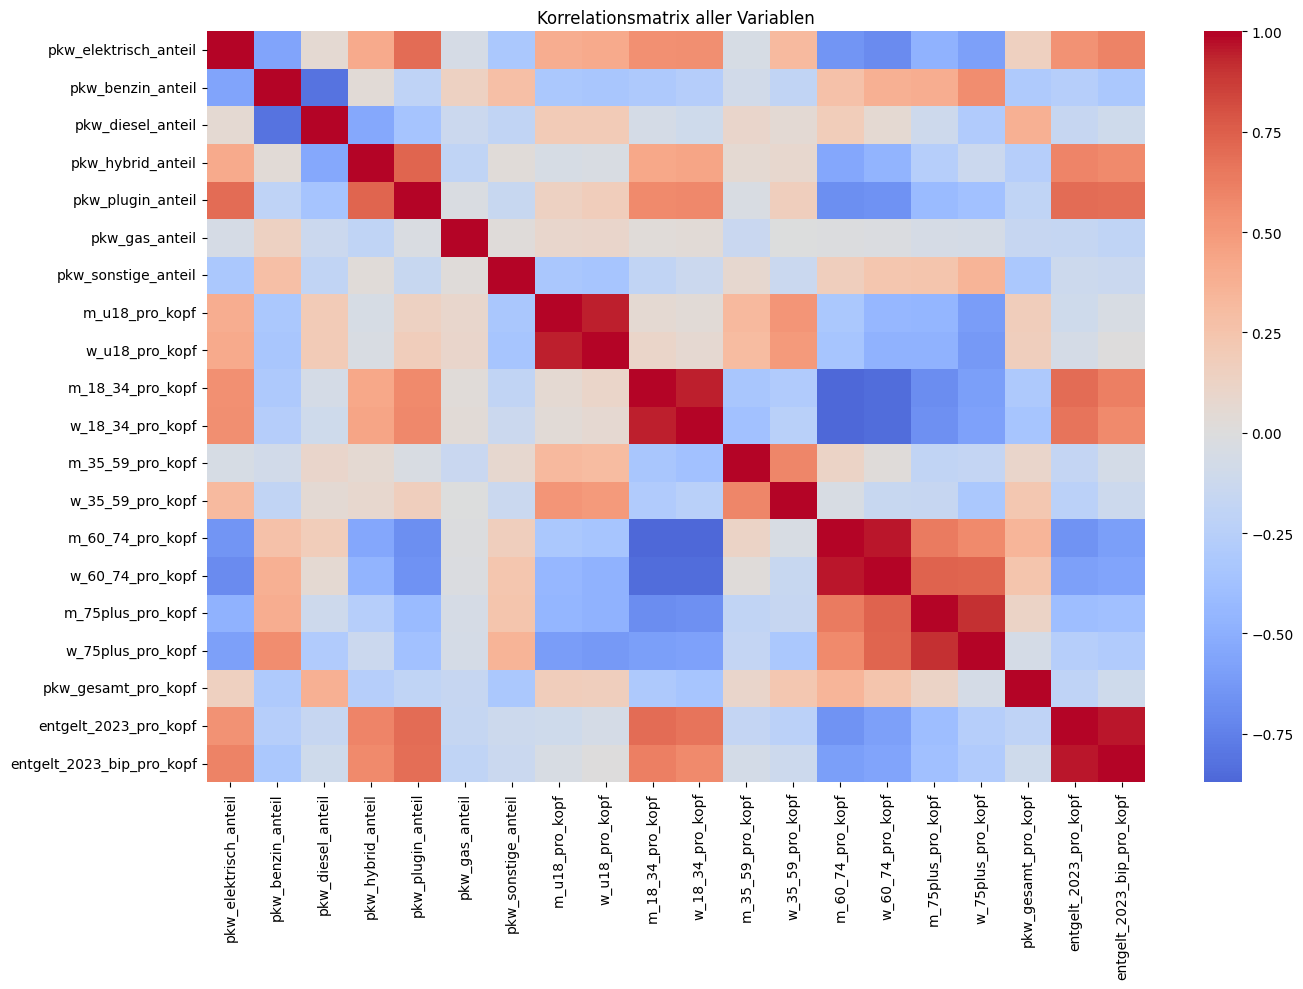

Korrelationen mit pkw_elektrisch_anteil:


pkw_elektrisch_anteil        1.000000
pkw_plugin_anteil            0.695842
entgelt_2023_bip_pro_kopf    0.599069
w_18_34_pro_kopf             0.547496
m_18_34_pro_kopf             0.544622
entgelt_2023_pro_kopf        0.537632
pkw_hybrid_anteil            0.415015
w_u18_pro_kopf               0.408677
m_u18_pro_kopf               0.389320
w_35_59_pro_kopf             0.318120
pkw_gesamt_pro_kopf          0.146025
pkw_diesel_anteil            0.059390
m_35_59_pro_kopf            -0.051128
pkw_gas_anteil              -0.059119
pkw_sonstige_anteil         -0.318636
m_75plus_pro_kopf           -0.483190
pkw_benzin_anteil           -0.559743
w_75plus_pro_kopf           -0.592031
m_60_74_pro_kopf            -0.650809
w_60_74_pro_kopf            -0.701413
Name: pkw_elektrisch_anteil, dtype: float64

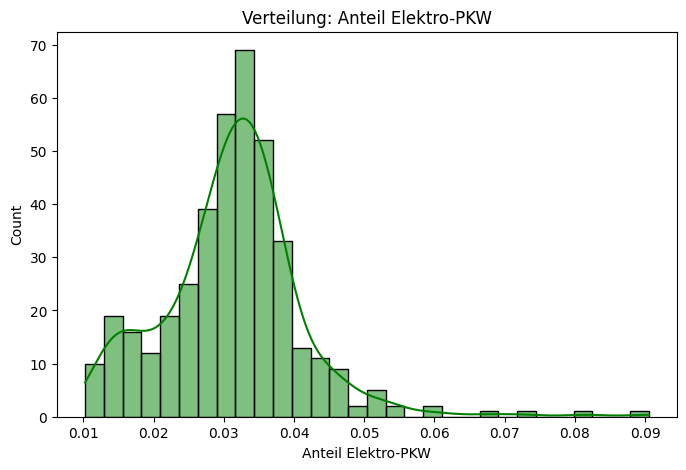

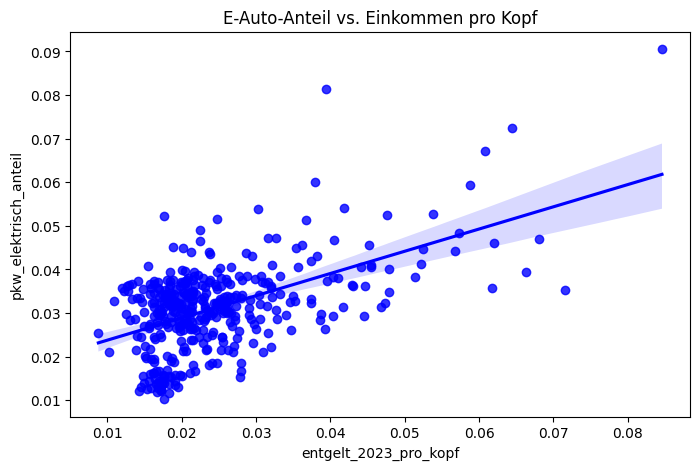

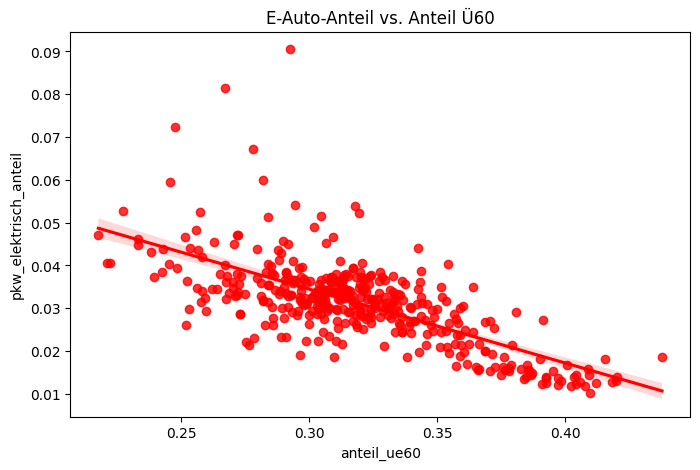

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1. DataFrames mergen
# -----------------------------
df = df_pkw_anteile.merge(df_pro_kopf, on=["kreis_id", "kreis_name"])

# -----------------------------
# 2. Auswahl relevanter Variablen
# -----------------------------
kor_vars = [
    "pkw_elektrisch_anteil",
    "pkw_benzin_anteil", "pkw_diesel_anteil", "pkw_hybrid_anteil",
    "pkw_plugin_anteil", "pkw_gas_anteil", "pkw_sonstige_anteil",
    "m_u18_pro_kopf", "w_u18_pro_kopf",
    "m_18_34_pro_kopf", "w_18_34_pro_kopf",
    "m_35_59_pro_kopf", "w_35_59_pro_kopf",
    "m_60_74_pro_kopf", "w_60_74_pro_kopf",
    "m_75plus_pro_kopf", "w_75plus_pro_kopf",
    "pkw_gesamt_pro_kopf",
    "entgelt_2023_pro_kopf", "entgelt_2023_bip_pro_kopf"
]

df_kor = df[kor_vars]

# -----------------------------
# 3. Korrelationsmatrix berechnen
# -----------------------------
corr = df_kor.corr(method="pearson")

# -----------------------------
# 4. Heatmap der gesamten Matrix
# -----------------------------
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Korrelationsmatrix aller Variablen")
plt.tight_layout()
plt.show()

# -----------------------------
# 5. Sortierte Korrelationen mit E-Auto-Anteil
# -----------------------------
print("Korrelationen mit pkw_elektrisch_anteil:")
display(corr["pkw_elektrisch_anteil"].sort_values(ascending=False))

# -----------------------------
# 6. Einfache Visualisierungen
# -----------------------------

# Histogramm der E-Auto-Quote
plt.figure(figsize=(8,5))
sns.histplot(df["pkw_elektrisch_anteil"], kde=True, color="green")
plt.title("Verteilung: Anteil Elektro-PKW")
plt.xlabel("Anteil Elektro-PKW")
plt.show()

# Scatterplot: Einkommen vs. E-Auto-Anteil
plt.figure(figsize=(8,5))
sns.regplot(data=df, x="entgelt_2023_pro_kopf", y="pkw_elektrisch_anteil", color="blue")
plt.title("E-Auto-Anteil vs. Einkommen pro Kopf")
plt.show()

# Scatterplot: Anteil Ü60 vs. E-Auto-Anteil
df["anteil_ue60"] = (
    df["m_60_74_pro_kopf"] + df["w_60_74_pro_kopf"] +
    df["m_75plus_pro_kopf"] + df["w_75plus_pro_kopf"]
)

plt.figure(figsize=(8,5))
sns.regplot(data=df, x="anteil_ue60", y="pkw_elektrisch_anteil", color="red")
plt.title("E-Auto-Anteil vs. Anteil Ü60")
plt.show()


In [67]:
%pip install scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 637.7 kB/s eta 0:00:0000:0100:02
Note: you may need to restart the kernel to use updated packages.


In [69]:
%pip install statsmodels

  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 3.9 MB/s eta 0:00:0000:010:01
Using cached patsy-1.0.2-py2.py3-none-any.whl (233 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]
Note: you may need to restart the kernel to use updated packages.


                              OLS Regression Results                             
Dep. Variable:     pkw_elektrisch_anteil   R-squared:                       0.788
Model:                               OLS   Adj. R-squared:                  0.785
Method:                    Least Squares   F-statistic:                     290.9
Date:                   Fri, 16 Jan 2026   Prob (F-statistic):          2.56e-129
Time:                           15:08:46   Log-Likelihood:                 1572.9
No. Observations:                    397   AIC:                            -3134.
Df Residuals:                        391   BIC:                            -3110.
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


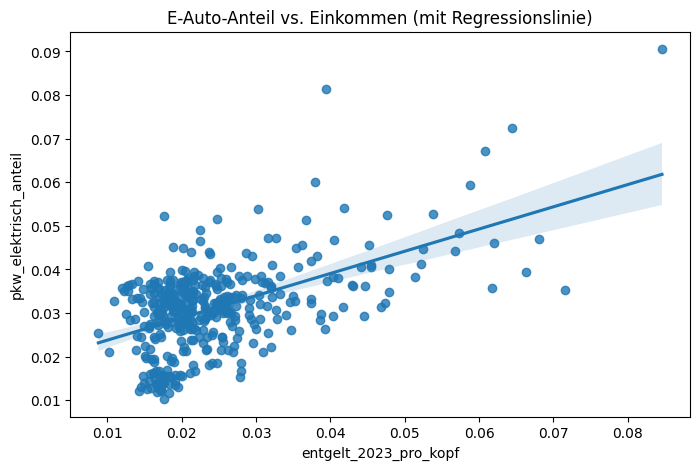

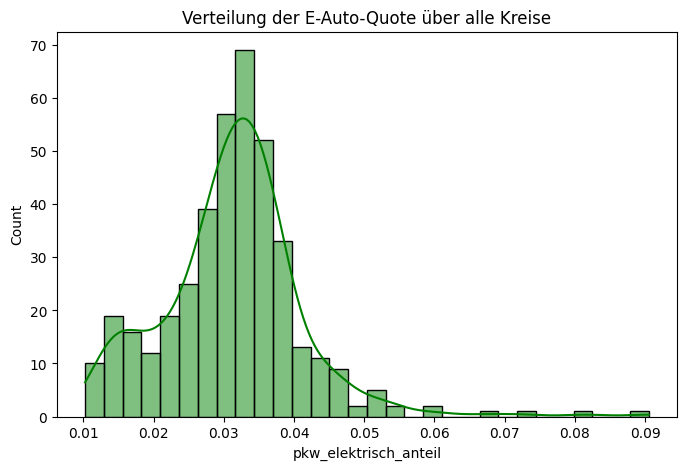

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

# -----------------------------
# 1. Merge der Kreisdaten
# -----------------------------
df = df_pkw_anteile.merge(df_pro_kopf, on=["kreis_id", "kreis_name"])

# Zielvariable
y = df["pkw_elektrisch_anteil"]

# Prädiktoren
X = df[[
    "entgelt_2023_pro_kopf",
    "pkw_diesel_anteil",
    "pkw_benzin_anteil",
    "m_60_74_pro_kopf",
    "m_75plus_pro_kopf"
]]

# -----------------------------
# 2. NaN/inf automatisch bereinigen
# -----------------------------
# Inf → NaN
X = X.replace([np.inf, -np.inf], np.nan)
y = y.replace([np.inf, -np.inf], np.nan)

# Gemeinsame Zeilen behalten
valid_idx = X.dropna().index.intersection(y.dropna().index)

X_clean = X.loc[valid_idx]
y_clean = y.loc[valid_idx]

# -----------------------------
# 3. Regression (fehlerfrei)
# -----------------------------
X_const = sm.add_constant(X_clean)
model = sm.OLS(y_clean, X_const).fit()

print(model.summary())

# -----------------------------
# 4. Scatterplot mit Regression
# -----------------------------
plt.figure(figsize=(8,5))
sns.regplot(data=df, x="entgelt_2023_pro_kopf", y="pkw_elektrisch_anteil")
plt.title("E-Auto-Anteil vs. Einkommen (mit Regressionslinie)")
plt.show()

# -----------------------------
# 5. Histogramm der E-Auto-Quote
# -----------------------------
plt.figure(figsize=(8,5))
sns.histplot(df["pkw_elektrisch_anteil"], kde=True, color="green")
plt.title("Verteilung der E-Auto-Quote über alle Kreise")
plt.show()


In [74]:
%pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [79]:
# Korrelationen mit Elektro-Anteil berechnen
df_analysis = df_pro_kopf.merge(df_pkw_anteile, on=["kreis_id", "kreis_name"])

target = "pkw_elektrisch_anteil"
correlations = df_analysis.corr(numeric_only=True)[target].sort_values(ascending=False)
print(correlations)


pkw_elektrisch_anteil        1.000000
pkw_elektrisch_pro_kopf      0.898962
pkw_plugin_pro_kopf          0.757070
pkw_plugin_anteil            0.695842
entgelt_2023_bip_pro_kopf    0.599069
w_18_34_pro_kopf             0.547496
m_18_34_pro_kopf             0.544622
entgelt_2023_pro_kopf        0.537632
pkw_hybrid_pro_kopf          0.483979
pkw_hybrid_anteil            0.415015
w_u18_pro_kopf               0.408677
m_u18_pro_kopf               0.389320
w_35_59_pro_kopf             0.318120
pkw_gesamt_pro_kopf          0.146025
pkw_diesel_pro_kopf          0.113959
pkw_diesel_anteil            0.059390
pkw_gas_pro_kopf            -0.019306
m_35_59_pro_kopf            -0.051128
pkw_gas_anteil              -0.059119
pkw_benzin_pro_kopf         -0.098181
pkw_sonstige_anteil         -0.318636
pkw_sonstige_pro_kopf       -0.328262
m_75plus_pro_kopf           -0.483190
pkw_benzin_anteil           -0.559743
w_75plus_pro_kopf           -0.592031
m_60_74_pro_kopf            -0.650809
w_60_74_pro_

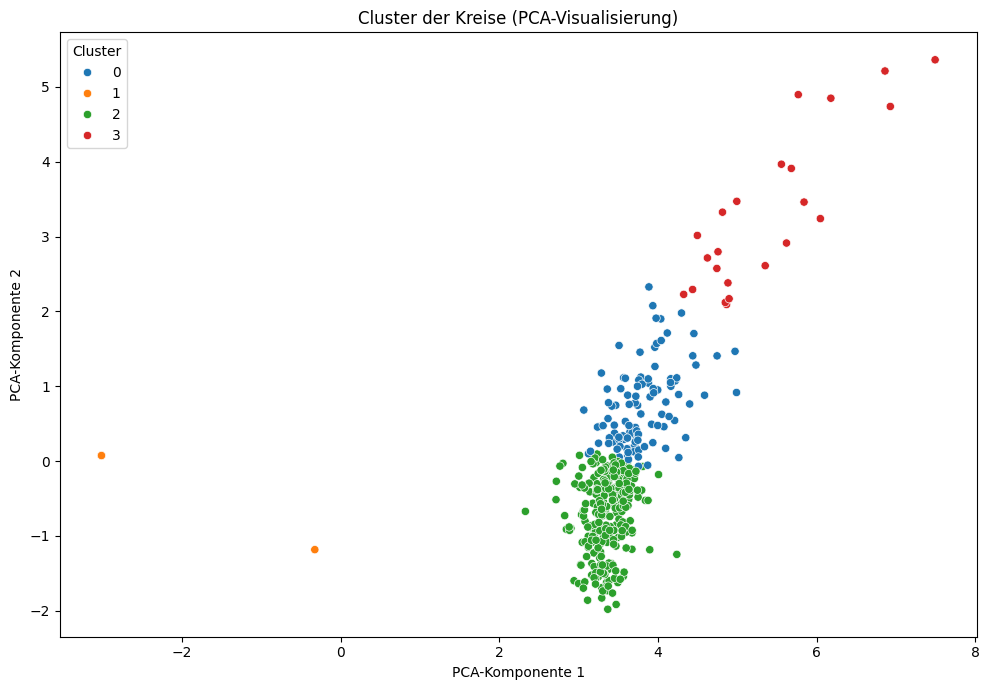

In [80]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Merge der Daten (falls noch nicht erfolgt)
# -----------------------------
df = df_pkw_anteile.merge(df_pro_kopf, on=["kreis_id", "kreis_name"])

# -----------------------------
# 2. Variablen für Clustering auswählen
# -----------------------------
cluster_vars = [
    "pkw_elektrisch_anteil",
    "pkw_diesel_anteil",
    "pkw_benzin_anteil",
    "pkw_hybrid_anteil",
    "pkw_plugin_anteil",
    "pkw_gesamt_pro_kopf",
    "entgelt_2023_pro_kopf",
    "entgelt_2023_bip_pro_kopf",
    "m_60_74_pro_kopf", "w_60_74_pro_kopf",
    "m_75plus_pro_kopf", "w_75plus_pro_kopf"
]

# -----------------------------
# 3. NaN-Werte durch 0 ersetzen
# -----------------------------
X = df[cluster_vars].copy()
X = X.fillna(0)

# -----------------------------
# 4. Standardisieren
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# 5. K-Means Clustering
# -----------------------------
kmeans = KMeans(n_clusters=4, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

# -----------------------------
# 6. PCA für 2D-Visualisierung
# -----------------------------
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)
df["pca1"] = pca_coords[:, 0]
df["pca2"] = pca_coords[:, 1]

# -----------------------------
# 7. Plot der Cluster
# -----------------------------
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x="pca1", y="pca2", hue="cluster", palette="tab10")
plt.title("Cluster der Kreise (PCA-Visualisierung)")
plt.xlabel("PCA-Komponente 1")
plt.ylabel("PCA-Komponente 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [82]:
%pip install geopandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.2/25.2 MB 4.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [geopandas]/4 [geopandas]
Note: you may need to restart the kernel to use updated packages.


In [84]:
%pip install folium

  Using cached folium-0.20.0-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached branca-0.8.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
Using cached folium-0.20.0-py2.py3-none-any.whl (113 kB)
Using cached branca-0.8.2-py3-none-any.whl (26 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [folium]
Note: you may need to restart the kernel to use updated packages.


In [99]:
import geopandas as gpd
import folium
from IPython.display import display

# 1) GeoJSON laden (lokal)
geo_path = "/Users/felixipfling/Documents/GitHub/codex_start/data/counties.json"
gdf = gpd.read_file(geo_path)

# --- Debug: Welche Spalten sind wirklich da? ---
print("GeoDF columns:", list(gdf.columns))
print(gdf[["id", "name"]].head(5))

# 2) Deine Daten vorbereiten
df_map = df_pkw_anteile[["kreis_id", "pkw_elektrisch_anteil"]].copy()
df_map["kreis_id"] = df_map["kreis_id"].astype(str).str.zfill(5)

# 3) Geo-Key ebenfalls sauber formatieren (id ist AGS)
gdf = gdf.copy()
gdf["id"] = gdf["id"].astype(str).str.zfill(5)

# 4) Merge
gdf_merged = gdf.merge(df_map, left_on="id", right_on="kreis_id", how="left")

# --- Debug: Match-Quote checken ---
na_share = gdf_merged["pkw_elektrisch_anteil"].isna().mean()
print(f"Anteil fehlender Werte nach Merge: {na_share:.2%}")

# 5) Karte erzeugen
m = folium.Map(location=[51.0, 10.0], zoom_start=6, tiles="CartoDB positron")

# 6) Choropleth (wichtig: geo_data als GeoJSON-Interface, key_on auf id)
folium.Choropleth(
    geo_data=gdf_merged.__geo_interface__,
    data=gdf_merged,
    columns=["id", "pkw_elektrisch_anteil"],     # <- nicht leer, sondern id
    key_on="feature.properties.id",              # <- nicht RS, sondern id
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Elektroauto-Anteil an allen PKW",
    nan_fill_color="lightgray",
).add_to(m)

# 7) Tooltip: nutze die Spalte, die du wirklich hast (bei dir sehr wahrscheinlich "name")
folium.GeoJson(
    gdf_merged.__geo_interface__,
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "pkw_elektrisch_anteil"],
        aliases=["Kreis", "E-Auto-Anteil"],
        localize=True
    )
).add_to(m)

display(m)


GeoDF columns: ['id', 'name', 'districtType', 'state', 'kfz', 'geometry']
      id             name
0  08425  Alb-Donau-Kreis
1  08115        Böblingen
2  08211      Baden-Baden
3  08426         Biberach
4  08435    Bodenseekreis
Anteil fehlender Werte nach Merge: 1.00%


In [100]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
from IPython.display import display

# ------------------------------------------------------------
# Ziel:
# - "Gesamtanteil" Elektro über ganz Deutschland berechnen:
#     total_ev / total_pkw
# - Pro Kreis den Elektro-Anteil (ev/pkw_gesamt) als Abweichung
#   vom Deutschland-Schnitt berechnen
# - Karte: grün = über Schnitt, rot = unter Schnitt
#   und jeweils abgestuft nach Stärke der Differenz
# ------------------------------------------------------------

# 1) GeoJSON laden (lokal) – id ist AGS (5-stellig)
geo_path = "/Users/felixipfling/Documents/GitHub/codex_start/data/counties.json"
gdf = gpd.read_file(geo_path).copy()
gdf["id"] = gdf["id"].astype(str).str.zfill(5)

# 2) Ausgangsdaten vorbereiten
# Erwartet: df_pkw hat absolute Zahlen (nicht Anteile):
#   - kreis_id
#   - pkw_elektrisch
#   - pkw_gesamt
df_base = df_pkw[["kreis_id", "pkw_elektrisch", "pkw_gesamt"]].copy()
df_base["kreis_id"] = df_base["kreis_id"].astype(str).str.zfill(5)

# Saubere Numerik (falls noch Strings)
for c in ["pkw_elektrisch", "pkw_gesamt"]:
    df_base[c] = pd.to_numeric(df_base[c], errors="coerce")

# Ungültige / 0-Zeilen raus (sonst Division/Noise)
df_base = df_base.dropna(subset=["pkw_elektrisch", "pkw_gesamt"])
df_base = df_base[df_base["pkw_gesamt"] > 0].copy()

# 3) Deutschland-Schnitt: (Summe EV) / (Summe PKW)
de_ev_total = df_base["pkw_elektrisch"].sum()
de_pkw_total = df_base["pkw_gesamt"].sum()
de_share = de_ev_total / de_pkw_total

print(f"Deutschland-Schnitt Elektro-Anteil: {de_share:.4%} (EV={de_ev_total:,.0f} / PKW={de_pkw_total:,.0f})")

# 4) Kreis-Anteil + Abweichung
df_base["ev_share"] = df_base["pkw_elektrisch"] / df_base["pkw_gesamt"]
df_base["diff"] = df_base["ev_share"] - de_share          # positiv = über Schnitt
df_base["diff_abs"] = df_base["diff"].abs()

# 5) Merge in GeoDF
gdfm = gdf.merge(df_base, left_on="id", right_on="kreis_id", how="left")

# ------------------------------------------------------------
# 6) Farbskala: rot unter Schnitt, grün über Schnitt
#    Intensität nach Stärke der Abweichung
# ------------------------------------------------------------
# Robust: Obergrenze der Intensität über Quantil, damit Ausreißer
# nicht alles platt machen
max_abs = np.nanquantile(gdfm["diff_abs"], 0.98)
if not np.isfinite(max_abs) or max_abs == 0:
    max_abs = np.nanmax(gdfm["diff_abs"])
    if not np.isfinite(max_abs) or max_abs == 0:
        max_abs = 1e-9

def clamp01(x: float) -> float:
    return max(0.0, min(1.0, x))

def color_from_diff(d: float) -> str:
    """
    d: diff = ev_share - deutschland_share
    Rot/Grün mit Abstufung:
      - d > 0 => grün
      - d < 0 => rot
    Intensität über |d| relativ zu max_abs.
    """
    if d is None or (isinstance(d, float) and np.isnan(d)):
        return "#d9d9d9"  # grau für fehlend

    t = clamp01(abs(d) / max_abs)

    # Wir bauen eine einfache RGB-Mischung:
    # - Start bei sehr hell (nahe weiß), Ende bei kräftig rot/grün.
    # - Rot:  (255, 230->0, 230->0)
    # - Grün: (230->0, 255, 230->0)
    # Das erzeugt eine saubere Abstufung ohne extra libs.
    if d >= 0:
        r = int(230 * (1 - t))
        g = 255
        b = int(230 * (1 - t))
    else:
        r = 255
        g = int(230 * (1 - t))
        b = int(230 * (1 - t))

    return f"#{r:02x}{g:02x}{b:02x}"

# ------------------------------------------------------------
# 7) Interaktive Karte
# ------------------------------------------------------------
m = folium.Map(location=[51.0, 10.0], zoom_start=6, tiles="CartoDB positron")

def style_function(feature):
    d = feature["properties"].get("diff", None)
    return {
        "fillColor": color_from_diff(d),
        "color": "#666666",
        "weight": 0.4,
        "fillOpacity": 0.8,
    }

tooltip = folium.GeoJsonTooltip(
    fields=["name", "ev_share", "diff"],
    aliases=["Kreis", "E-Anteil (Kreis)", "Abweichung ggü. DE-Schnitt"],
    localize=True,
    sticky=True
)

folium.GeoJson(
    gdfm.__geo_interface__,
    style_function=style_function,
    tooltip=tooltip,
    name="Über/Unter DE-Schnitt (Elektro-Anteil)"
).add_to(m)

# ------------------------------------------------------------
# 8) Kleine Legende (HTML), damit klar ist was grün/rot bedeutet
# ------------------------------------------------------------
legend_html = f"""
<div style="
    position: fixed;
    bottom: 30px; left: 30px; width: 320px;
    background: white; border: 1px solid #999;
    padding: 10px; z-index: 9999; font-size: 14px;
">
  <div><b>Elektro-Anteil vs. Deutschland-Schnitt</b></div>
  <div>Deutschland-Schnitt: <b>{de_share:.2%}</b></div>
  <div style="margin-top:8px;">
    <span style="display:inline-block;width:14px;height:14px;background:#ff0000;border:1px solid #999;vertical-align:middle;"></span>
    <span style="vertical-align:middle;">unter Schnitt (stärker = dunkler)</span>
  </div>
  <div style="margin-top:6px;">
    <span style="display:inline-block;width:14px;height:14px;background:#00ff00;border:1px solid #999;vertical-align:middle;"></span>
    <span style="vertical-align:middle;">über Schnitt (stärker = dunkler)</span>
  </div>
  <div style="margin-top:8px;color:#444;">
    Skala basiert auf |Abweichung| (bis 98%-Quantil), damit Ausreißer nicht alles dominieren.
  </div>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

display(m)


Deutschland-Schnitt Elektro-Anteil: 3.3470% (EV=3,299,450 / PKW=98,579,790)


In [101]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
from IPython.display import display

# ------------------------------------------------------------
# Ziel:
# - Für entgelt_2023_pro_kopf und entgelt_2023_bip_pro_kopf jeweils:
#   * Deutschland-Schnitt (Mean, damit vergleichbar zu "Durchschnitt Kreis")
#   * Abweichung pro Kreis (Kreiswert - DE-Schnitt)
#   * Karte: grün über Schnitt, rot unter Schnitt, Intensität nach Stärke
# ------------------------------------------------------------

# 0) Geo laden (lokal) – id ist AGS (5-stellig)
geo_path = "/Users/felixipfling/Documents/GitHub/codex_start/data/counties.json"
gdf = gpd.read_file(geo_path).copy()
gdf["id"] = gdf["id"].astype(str).str.zfill(5)

# 1) Daten aus df_pro_kopf holen
df_map = df_pro_kopf[[
    "kreis_id",
    "kreis_name",
    "entgelt_2023_pro_kopf",
    "entgelt_2023_bip_pro_kopf"
]].copy()

df_map["kreis_id"] = df_map["kreis_id"].astype(str).str.zfill(5)

# Numerik sichern
for c in ["entgelt_2023_pro_kopf", "entgelt_2023_bip_pro_kopf"]:
    df_map[c] = pd.to_numeric(df_map[c], errors="coerce")

# 2) Merge in Geo
gdfm = gdf.merge(df_map, left_on="id", right_on="kreis_id", how="left")

# ------------------------------------------------------------
# Helper: Diverging-Style (grün/rot) für eine Variable
# ------------------------------------------------------------
def make_diverging_map(gdfm: gpd.GeoDataFrame, value_col: str, title: str):
    """
    value_col: Spalte in gdfm mit numerischen Werten (pro Kopf)
    title: Layer-/Legendentitel
    """

    # a) Deutschland-"Schnitt" als arithmetisches Mittel über Kreise
    # (bei "pro Kopf" meist sinnvoll, weil es nicht vom Kreisvolumen dominiert wird)
    de_mean = np.nanmean(gdfm[value_col].values)

    # b) diff = Kreis - DE-Mean
    tmp = gdfm.copy()
    tmp["diff"] = tmp[value_col] - de_mean
    tmp["diff_abs"] = tmp["diff"].abs()

    # c) robuste Skala für Intensität (98%-Quantil)
    max_abs = np.nanquantile(tmp["diff_abs"], 0.98)
    if not np.isfinite(max_abs) or max_abs == 0:
        max_abs = np.nanmax(tmp["diff_abs"])
        if not np.isfinite(max_abs) or max_abs == 0:
            max_abs = 1e-9

    def clamp01(x: float) -> float:
        return max(0.0, min(1.0, x))

    def color_from_diff(d: float) -> str:
        if d is None or (isinstance(d, float) and np.isnan(d)):
            return "#d9d9d9"  # grau für fehlend

        t = clamp01(abs(d) / max_abs)

        # Hell -> kräftig: über Schnitt grün, unter Schnitt rot
        if d >= 0:
            r = int(230 * (1 - t))
            g = 255
            b = int(230 * (1 - t))
        else:
            r = 255
            g = int(230 * (1 - t))
            b = int(230 * (1 - t))

        return f"#{r:02x}{g:02x}{b:02x}"

    # d) Karte
    m = folium.Map(location=[51.0, 10.0], zoom_start=6, tiles="CartoDB positron")

    def style_function(feature):
        d = feature["properties"].get("diff", None)
        return {
            "fillColor": color_from_diff(d),
            "color": "#666666",
            "weight": 0.4,
            "fillOpacity": 0.8,
        }

    tooltip = folium.GeoJsonTooltip(
        fields=["name", value_col, "diff"],
        aliases=["Kreis", f"{title} (Kreis)", "Abweichung ggü. DE-Schnitt"],
        localize=True,
        sticky=True
    )

    folium.GeoJson(
        tmp.__geo_interface__,
        style_function=style_function,
        tooltip=tooltip,
        name=title
    ).add_to(m)

    # e) Legende
    legend_html = f"""
    <div style="
        position: fixed;
        bottom: 30px; left: 30px; width: 360px;
        background: white; border: 1px solid #999;
        padding: 10px; z-index: 9999; font-size: 14px;
    ">
      <div><b>{title}</b></div>
      <div>Deutschland-Schnitt (Mean über Kreise): <b>{de_mean:.4f}</b></div>
      <div style="margin-top:8px;">
        <span style="display:inline-block;width:14px;height:14px;background:#ff0000;border:1px solid #999;vertical-align:middle;"></span>
        <span style="vertical-align:middle;">unter Schnitt (stärker = dunkler)</span>
      </div>
      <div style="margin-top:6px;">
        <span style="display:inline-block;width:14px;height:14px;background:#00ff00;border:1px solid #999;vertical-align:middle;"></span>
        <span style="vertical-align:middle;">über Schnitt (stärker = dunkler)</span>
      </div>
      <div style="margin-top:8px;color:#444;">
        Skala basiert auf |Abweichung| (bis 98%-Quantil).
      </div>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))

    return m


# ------------------------------------------------------------
# 3) Karten erzeugen (zwei Outputs)
# ------------------------------------------------------------

# Einkommen pro Kopf (bei dir: Arbeitnehmerentgelt pro Kopf)
m_income = make_diverging_map(
    gdfm=gdfm,
    value_col="entgelt_2023_pro_kopf",
    title="Einkommen (Arbeitnehmerentgelt) pro Kopf"
)
display(m_income)

# BIP pro Kopf
m_gdp = make_diverging_map(
    gdfm=gdfm,
    value_col="entgelt_2023_bip_pro_kopf",
    title="BIP pro Kopf"
)
display(m_gdp)


In [109]:
%pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 1.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [ipywidgets]
Note: you may need to restart the kernel to use updated packages.


In [1]:
# ============================================================
# Wissenschaftlich saubere Regressionsanalyse (Kreisebene)
# Ziel: Treiber der E-Auto-Verbreitung, OHNE kompositionelle Anteile
# ------------------------------------------------------------
# Warum nicht Benzin-/Diesel-Anteile?
#   Kraftstoff-ANTEILE sind kompositionelle Daten (summieren sich ~ auf 1).
#   Wenn du den E-Anteil erklärst und gleichzeitig Benzin-/Diesel-Anteil als
#   Prädiktoren nutzt, entsteht ein mechanischer Zusammenhang: Mehr Benzin
#   bedeutet automatisch weniger Elektro (und umgekehrt). Das produziert:
#     - künstlich hohes R²
#     - instabile Koeffizienten / Vorzeichenwechsel
#     - Multikollinearität
#
# Deshalb modellieren wir stattdessen:
#   (A) E-Autos pro Kopf (Adoption-Intensität)
#   (B) E-Auto-Anteil an allen PKW (Kompositionsgröße), aber OHNE andere Anteile
#
# Wir nutzen robuste Standardfehler (HC3), damit Heteroskedastizität
# (typisch bei Kreisdaten) die Inferenz weniger verzerrt.
# ============================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm

# -----------------------------
# 0) Datenbasis wählen
# -----------------------------
# Erwartung: df_master enthält absolute Größen und/oder df_pro_kopf enthält *_pro_kopf.
# Du hast bereits df_pro_kopf und df_pkw_anteile. Wir bauen eine Analyse-Tabelle daraus.

# Falls df_pro_kopf bereits PKW pro Kopf etc. enthält und df_pkw_anteile den E-Anteil:
df = df_pro_kopf.merge(
    df_pkw_anteile[["kreis_id", "kreis_name", "pkw_elektrisch_anteil"]],
    on=["kreis_id", "kreis_name"],
    how="inner"
).copy()

# -----------------------------
# 1) Zielvariablen definieren
# -----------------------------
# (A) Adoption-Intensität: E-Autos pro Kopf
#     -> weniger "mechanisch" als ein Anteil, gut interpretierbar
y_adoption = "pkw_elektrisch_pro_kopf"

# (B) Kompositionsziel: E-Anteil an allen PKW
#     -> interpretierbar, aber bleibt eine Anteilvariable (0..1)
y_share = "pkw_elektrisch_anteil"

# -----------------------------
# 2) Prädiktoren wählen (ohne Benzin/Diesel-Anteile)
# -----------------------------
# Minimal sinnvolle Struktur:
#   - Einkommen pro Kopf (Arbeitsnehmerentgelt pro Kopf)
#   - BIP pro Kopf (oder alternativ: nur eines davon, um Multikollinearität zu senken)
#   - Altersstruktur (Anteile pro Kopf, getrennt nach Kohorten)
#   - Motorisierung: PKW pro Kopf (Kontrollvariable: mehr PKW pro Kopf -> mehr Potenzial)
#
# Hinweis:
#   entgelt_2023_bip_pro_kopf ist bei dir vermutlich BIP pro Kopf (der Name ist etwas schief).
#   Wenn du wirklich "BIP2023_pro_kopf" hast, nimm lieber die sauber benannte Variable.

X_vars = [
    "entgelt_2023_pro_kopf",          # Proxy für Einkommen
    "entgelt_2023_bip_pro_kopf",      # Proxy für Wirtschaftsleistung (BIP) pro Kopf
    "pkw_gesamt_pro_kopf",            # Motorisierung / Autodichte (Kontrolle)
    "m_18_34_pro_kopf", "w_18_34_pro_kopf",
    "m_60_74_pro_kopf", "w_60_74_pro_kopf",
    "m_75plus_pro_kopf", "w_75plus_pro_kopf",
]

# -----------------------------
# 3) Saubere Analyse-Stichprobe bauen
# -----------------------------
# Wir entfernen Kreise mit fehlenden Werten in Ziel oder Prädiktoren
needed_cols = [y_adoption, y_share] + X_vars
df_model = df.dropna(subset=needed_cols).copy()

# Optional: Extremwerte abfangen (nur falls nötig)
# df_model = df_model[(df_model[y_adoption] >= 0) & (df_model[y_share].between(0,1))]

print("N (Analyse-Stichprobe):", len(df_model))

# -----------------------------
# 4) OLS-Funktion mit robusten Standardfehlern (HC3)
# -----------------------------
def fit_ols_robust(df_in: pd.DataFrame, y: str, X_list: list[str]):
    """
    Schätzt ein lineares OLS-Modell mit robusten Standardfehlern (HC3).
    Gibt Modellobjekt zurück + eine kompakte, 'paper-taugliche' Ergebnis-Tabelle.
    """
    X = df_in[X_list].astype(float)
    X = sm.add_constant(X)  # Intercept
    yv = df_in[y].astype(float)

    model = sm.OLS(yv, X).fit(cov_type="HC3")  # robuste SE
    # Ergebnis-Tabelle: Koeff, SE, t, p, CI
    res = pd.DataFrame({
        "coef": model.params,
        "std_err(HC3)": model.bse,
        "t": model.tvalues,
        "p": model.pvalues,
        "ci_low": model.conf_int().iloc[:, 0],
        "ci_high": model.conf_int().iloc[:, 1],
    })
    return model, res

# -----------------------------
# 5) Modell A: E-Autos pro Kopf (Adoption)
# -----------------------------
model_A, table_A = fit_ols_robust(df_model, y_adoption, X_vars)

print("\n" + "="*80)
print("MODELL A: Determinanten von E-Autos pro Kopf (Adoption-Intensität)")
print("OLS mit robusten Standardfehlern (HC3), Kreisebene")
print("="*80)
print(model_A.summary())

print("\nErgebnistabelle (HC3 robust):")
display(table_A)

# Interpretation-Hinweise (als Kommentar, direkt wissenschaftlich verwendbar):
# - Ein positives Vorzeichen bei entgelt_2023_pro_kopf bedeutet: Kreise mit höherem Einkommen
#   weisen (ceteris paribus) mehr E-Autos pro Einwohner auf.
# - pkw_gesamt_pro_kopf kontrolliert Motorisierung: ohne diese Kontrolle könnte Einkommen nur
#   "mehr Autos insgesamt" abbilden. Mit Kontrolle wird es eher "Elektrifizierung" im engeren Sinn.
# - Alterskohorten interpretierst du als Strukturvariablen: höhere Anteile 60+ sollten typischerweise
#   mit geringerer Adoption zusammenhängen (Neuwagenanteil, Präferenzen etc.).

# -----------------------------
# 6) Modell B: E-Anteil an allen PKW (ohne andere Anteile)
# -----------------------------
model_B, table_B = fit_ols_robust(df_model, y_share, X_vars)

print("\n" + "="*80)
print("MODELL B: Determinanten des E-Auto-Anteils an allen PKW")
print("OLS mit robusten Standardfehlern (HC3), Kreisebene")
print("Hinweis: Ziel ist ein Anteil (0..1). Interpretation als lineares Wahrscheinlichkeitsmodell.")
print("="*80)
print(model_B.summary())

print("\nErgebnistabelle (HC3 robust):")
display(table_B)

# -----------------------------
# 7) Optional: Multikollinearität checken (VIF)
# -----------------------------
# Einkommen und BIP pro Kopf sind häufig stark korreliert.
# Wenn VIF sehr hoch ist, nimm empirisch lieber NUR eine von beiden Variablen
# (z.B. nur entgelt_2023_pro_kopf ODER nur BIP pro Kopf) oder baue einen Index.

from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = sm.add_constant(df_model[X_vars].astype(float))
vif = pd.DataFrame({
    "variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print("\nVIF-Check (Faustregel: > 5 problematisch, > 10 sehr problematisch):")
display(vif)

# -----------------------------
# 8) Wissenschaftlich "cleaner" Varianten (wenn VIF hoch):
# -----------------------------
# Variante A1: nur Einkommen (ohne BIP)
# Variante A2: nur BIP (ohne Einkommen)
# So kannst du zeigen, dass das Ergebnis robust gegenüber Spezifikationen ist.

X_vars_income_only = [v for v in X_vars if v != "entgelt_2023_bip_pro_kopf"]
X_vars_gdp_only    = [v for v in X_vars if v != "entgelt_2023_pro_kopf"]

model_A1, table_A1 = fit_ols_robust(df_model, y_adoption, X_vars_income_only)
model_A2, table_A2 = fit_ols_robust(df_model, y_adoption, X_vars_gdp_only)

print("\n" + "="*80)
print("ROBUSTHEIT: Modell A1 (nur Einkommen, ohne BIP)")
print("="*80)
print(model_A1.summary())

print("\n" + "="*80)
print("ROBUSTHEIT: Modell A2 (nur BIP, ohne Einkommen)")
print("="*80)
print(model_A2.summary())

# Tipp für wissenschaftlichen Output:
# - Berichte mindestens ein Hauptmodell + 1 Robustheitscheck.
# - Diskutiere Vorzeichen und Größenordnung (Effektstärke) und nicht nur p-Werte.
# - Erwähne Einschränkungen: Querschnittsdaten, mögliche omitted variables (Urbanität, Ladeinfrastruktur, Firmenwagen etc.).


NameError: name 'df_pro_kopf' is not defined